In [1]:
import pandas as pd
import glob
import numpy as np
import re
import matplotlib

In [2]:
allFiles = glob.glob("PJM/*.xls")
files_set1 = allFiles[:7]
files_set2 = allFiles[13:]
files_set3 = allFiles[7:13]

In [3]:
def rename_col(x):
    col_name = ''
    if isinstance(x,int):
        col_name =  'hour0'+ str(x) if x < 10 else 'hour' + str(x)
    elif (re.match('.*DATE.*', x) is not None) or x == 'DD':
        col_name = 'Date'
    elif x == 'ZONE_NAME' or x == 'CC' or x == 'COMP':
        col_name = 'Zone'
    else:
        if x.isdigit():
            col_name = 'hour0' + x if int(x) < 10 else 'hour' + x
        elif x[0:2] == 'HE':
            col_name = 'hour' + x[2:]
        elif x[0] == 'H':
            col_name = 'hour0' + x[1:] if int(x[1:]) < 10 else 'hour' + x[1:]
        else:
            col_name = x
    return col_name

In [4]:
pjm_set1 = pd.DataFrame()
list_ = []
for f in files_set1:
    df = pd.ExcelFile.parse(pd.ExcelFile(f),index_col=None, header=0)
    df.columns = df.columns.map(rename_col)
    list_.append(df)
pjm_set1 = pd.concat(list_)

In [5]:
pjm_set2 = pd.DataFrame()
list_ = []
for f in files_set2:
    xlfile = pd.ExcelFile(f)
    df_list = [xlfile.parse(sheet,index_col=None, header=0, parse_cols = 25) for sheet in xlfile.sheet_names[3:]]
    df = pd.concat(df_list)
    df.columns = df.columns.map(rename_col)
    list_.append(df)
pjm_set2 = pd.concat(list_)

WARNING *** file size (6225792) not 512 + multiple of sector size (512)


In [6]:
pjm_set3 = pd.DataFrame()
list_ = []
for f in files_set3:
    xlfile = pd.ExcelFile(f)
    df_list = [xlfile.parse(sheet,index_col=None, header=0, parse_cols = 25) for sheet in xlfile.sheet_names[2:]]
    df = pd.concat(df_list)
    df.columns = df.columns.map(rename_col)
    list_.append(df)
pjm_set3 = pd.concat(list_)

In [7]:
pjm = pd.concat([pjm_set1, pjm_set2, pjm_set3])

In [8]:
list_ = []
for col in pjm.columns[2:]:
    df = pd.DataFrame()
    df['Zone'] = pjm['Zone']
    df['Date'] = pjm['Date']
    df['Demand'] = pjm[col]
    df['Hour'] = int(col[4:])
    list_.append(df)
pjm = pd.concat(list_)

pjm['Zone'] = 'PJM ' + pjm['Zone'].astype(str)

In [68]:
%matplotlib inline
import matplotlib.pyplot as plt # side-stepping mpl backend
import matplotlib.gridspec as gridspec # subplots

In [127]:
def draw_lineplot(data, zone):
    fig = plt.figure(1, figsize=(30, 16))
    ax = fig.add_subplot(111)
    ax.plot(data['Hour'], data['Demand'])
    fig.savefig('meanload_' + zone + '.png')
    plt.close()

In [128]:
mean_load = pjm.groupby(['Zone','Hour'], as_index=False).mean()
zones = mean_load['Zone'].unique()

for z in zones:
    load_z = mean_load[mean_load['Zone'] == z]
    draw_lineplot(load_z, z)

In [130]:
def draw_boxplot(load_data, zone):
    fig = plt.figure(1, figsize=(365, 16))
    ax = fig.add_subplot(111)

    # Create the boxplot
    bp = ax.boxplot(load_data, patch_artist=True)

    for flier in bp['fliers']:
        flier.set(marker='o', color='#e7298a', alpha=0.5)

    # Save the figure
    fig.savefig('outlier_' + zone + '.png', bbox_inches='tight')
    plt.close()

In [131]:
test = pjm[pjm['Date'].apply(lambda x: pd.to_datetime(x).year == 2014)]
daily_load = test.groupby(['Zone', 'Date'], as_index=False).apply(lambda x:x.set_index('Hour').to_dict('dict')['Demand'])

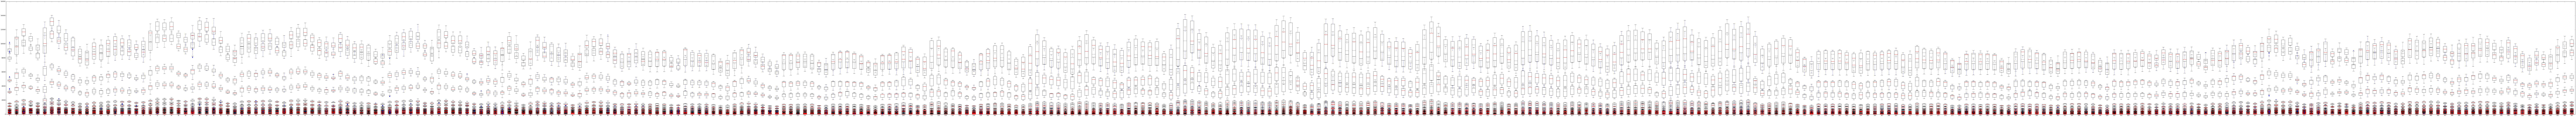

In [132]:
zones = daily_load.index.get_level_values('Zone').unique()
for z in zones:
    load_data = []
    for d in daily_load[z]:
        load_data.append([d[t] for t in d.keys()])
    draw_boxplot(load_data, z)